<a href="https://colab.research.google.com/github/SandhiyaAcharya/Emotion_Analysis/blob/main/Emotion_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

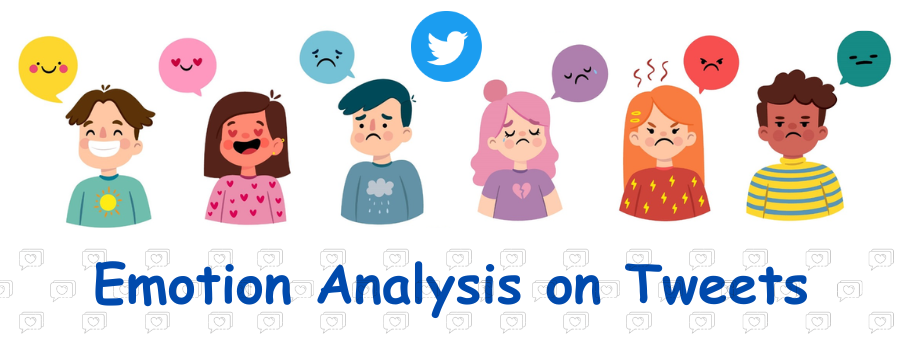

## Setting the Environment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install neattext
!pip install textblob
!pip install transformers
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 12.0 MB/s eta 0:00:00


## Import Libraries

In [3]:
import pandas as pd
import seaborn as sns
import neattext as nt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download("wordnet")
from textblob import TextBlob
import contractions
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D, Dense,Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import pad_sequences
import numpy as np
from keras.layers import LSTM, Flatten, BatchNormalization,Activation
from tensorflow.keras.layers import Dense, Dropout,InputLayer
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
#Load dataset
data=pd.read_csv("/content/drive/MyDrive/Colab_Datasets/emotion_dataset.csv")
data.head()

,Emotion,Text
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


In [5]:
#Renaming the column name
data.rename(columns={"Emotion": "emotion"}, inplace=True)
data.rename(columns={"Text": "content"}, inplace=True)

In [6]:
data.shape

(34792, 2)

In [7]:
data.isnull().sum()

emotion    0
content    0
dtype: int64

In [8]:
#Removing the empty string from “emotion” and eliminating zeros from the “content” .
data = data[data["emotion"].str.contains("empty") == False]
data = data[data["content"].str.contains("0") == False]

In [9]:
data.head()

,emotion,content
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


In [10]:
(data['content']==0).sum()

0

In [11]:
data['emotion'].unique()

array(['neutral', 'joy', 'sadness', 'fear', 'surprise', 'anger', 'shame',
       'disgust'], dtype=object)

[Text(0, 0, 'neutral'),
 Text(1, 0, 'joy'),
 Text(2, 0, 'sadness'),
 Text(3, 0, 'fear'),
 Text(4, 0, 'surprise'),
 Text(5, 0, 'anger'),
 Text(6, 0, 'shame'),
 Text(7, 0, 'disgust')]

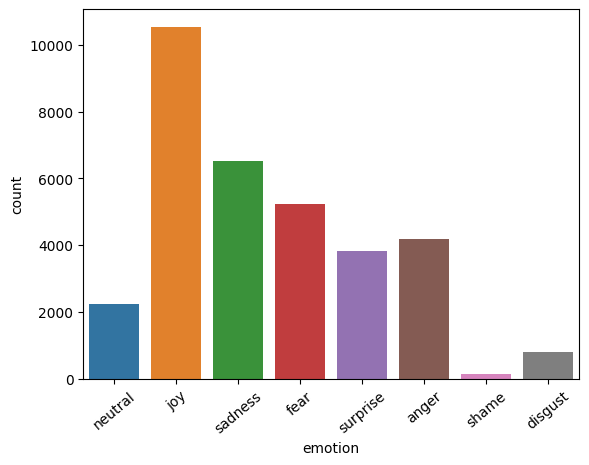

In [12]:
emotions_count=sns.countplot(x='emotion',data=data)
emotions_count.set_xticklabels(emotions_count.get_xticklabels(), rotation=40)

## Text Processing

In [14]:
data.head()

,emotion,content
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


**Lowercasing-**  Convert all text to lowercase. This ensures uniformity and helps in reducing the dimensionality of the data.

In [15]:
data['content']=data['content'].str.lower()
data.head()

,emotion,content
0,neutral,why ?
1,joy,sage act upgrade on my to do list for tommorow.
2,sadness,on the way to my homegirl baby funeral!!! man ...
3,joy,such an eye ! the true hazel eye-and so brill...
4,joy,@iluvmiasantos ugh babe.. hugggzzz for u .! b...


**Handling HTML Tags, emojis, emails and URLs-** If dealing with web data then remove HTML tags, URLS, emojis, emails.

In [16]:
data['content'] = data['content'].apply(lambda text: nt.remove_html_tags(text))
data['content']= data['content'].apply(lambda text: nt.remove_urls(text))
data['content']= data['content'].apply(lambda text: nt.remove_emojis(text))
data['content']= data['content'].apply(lambda text: nt.remove_emails(text))


**Removing Special Characters and Numbers-** Remove any non-alphabetic characters and numbers. These often do not contribute to the semantics of the text.

In [17]:
# Use regular expression to remove non-alphabetic characters and numbers
# def remove_special_chars_and_numbers(text):
#     cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
#     return cleaned_text
# data['content']=[remove_special_chars_and_numbers(text) for text in data['content']]
# data.head()

data['content']= data['content'].apply(lambda text: nt.remove_special_characters(text))
data['content']= data['content'].apply(lambda text: nt.remove_numbers(text))



**Handling Contractions-** Expand contractions (e.g., "can't" to "cannot")

In [18]:
# vaex_data['content']= vaex_data['content'].apply(lambda text: nt.fix_contractions(text))
data['content']= data['content'].apply(lambda text:  contractions.fix(text))



**Removing Punctuation-** Remove all punctuation marks (e.g., periods, commas, exclamation marks) as they generally do not carry much information for many NLP tasks.



In [19]:
# Using regular expression to remove punctuation
# def remove_punctuation(text):
#     cleaned_text = re.sub(r'[^\w\s]', '', text)
#     return cleaned_text
# data['content']=[remove_punctuation(text) for text in data['content']]
# data.head()

#Using NeatText
data['content']= data['content'].apply(lambda text: nt.remove_punctuations(text))

**Removing Stopwords-**  Remove common, low-information words (e.g., "and", "the", "in") known as stopwords.

In [20]:
data['content']= data['content'].apply(lambda text: nt.remove_stopwords(text))

**Removing Stopwords-**  Remove common, low-information words (e.g., "and", "the", "in") known as stopwords.

In [21]:
data['content']= data['content'].apply(lambda text: nt.remove_stopwords(text))


**Tokenization-** Split the text into individual words or tokens. This makes it easier to analyze and process.

In [22]:
data['content']= data['content'].apply(lambda text: word_tokenize(text))


**Lemmatization-** Reduce words to their base or root form. This helps in reducing the dimensionality of the feature space.

In [23]:
lemmatizer = WordNetLemmatizer()
data['content'] = data['content'].apply(lambda text: [lemmatizer.lemmatize(word,pos='v') for word in text])

Label encoding is a technique used to convert categorical data, specifically labels or classes, into numerical values.

In [24]:
label_encoder = preprocessing.LabelEncoder()

data['emotion']= label_encoder.fit_transform(data['emotion'])

data['emotion'].unique()

array([4, 3, 5, 2, 7, 0, 6, 1])

## Data Spliting
Splitting the data into training, validation, and testing sets.



The training set is the portion of the data used to train model.

The validation set is used during the training process to evaluate the model's performance and fine-tune hyperparameters. It helps in preventing overfitting. The validation set is not used for training.

The testing set is used after the model is trained to provide an unbiased evaluation of the final model's performance.

In [25]:
X = data['content']
y = data['emotion']

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)  # 70% training, 30% temp

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)  # 15% validation, 15% testing


In [26]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((23448,), (23448,), (5025,), (5025,), (5025,), (5025,))

Checking the distribution of the data with respect to emotion

In [27]:
print("-----y train-----\n",y_train.value_counts())
print("-----y test-----\n",y_test.value_counts())

-----y train-----
 3    7301
5    4575
2    3701
0    2977
7    2662
4    1544
1     571
6     117
Name: emotion, dtype: int64
-----y test-----
 3    1600
5    1011
2     763
0     616
7     566
4     318
1     136
6      15
Name: emotion, dtype: int64


## Preparing embedding layer

###Tokenization
Tokenization is the process of converting text into a sequence of numerical values, where each unique word is assigned a unique integer index.

In [28]:
word_tokenizer= Tokenizer()
word_tokenizer.fit_on_texts(X_train)
X_train= word_tokenizer.texts_to_sequences(X_train)
X_test= word_tokenizer.texts_to_sequences(X_test)
X_val= word_tokenizer.texts_to_sequences(X_val)

The input_dim parameter should be the size of your vocabulary, i.e. the set of all unique words present.

In [29]:
vocab_length= len(word_tokenizer.word_index)+1
vocab_length

26904

 ### Padding
 It ensures that the sequences of integers representing the text data have a consistent length.


In [30]:
maxlen= 50 #Padding to fixed length 50
X_train=pad_sequences(X_train, padding='post',maxlen=maxlen)
X_test=pad_sequences(X_test, padding='post',maxlen=maxlen)
X_val=pad_sequences(X_val, padding='post',maxlen=maxlen)

### Word Embedding

Word embedding is a way to represent words as vectors (arrays of numbers) in such a way that the meaning of words is captured based on their context and relationships with other words.

Here’s how we can create word embeddings using pre-trained embeddings

In [31]:
# Load GloVe (Global Vectors for Word Representation) word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/Colab_Datasets/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [32]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [33]:
embedding_matrix.shape

(26904, 100)

## Model

### Convolutional Neural Network

In [ ]:
# Define the model
cnn_model = Sequential()

# Embedding Layer:
cnn_model.add(Embedding(input_dim=vocab_length, output_dim=100,weights=[embedding_matrix], input_length=maxlen))

# Convolutional Layers:
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())

# Dense Layers:
cnn_model.add(Dense(64, kernel_regularizer=l2(0.01)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.1))  # Adding Dropout with 10%
cnn_model.add(Dense(8, activation='softmax')) #8 emotions


In [ ]:
# Compile the model:
from keras.optimizers import SGD
opt = SGD(learning_rate = 0.001)
cnn_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2690400   
                                                                 
 conv1d (Conv1D)             (None, 46, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64)                0

In [ ]:
# Model training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1,validation_data=(X_val, y_val),callbacks=[early_stop])


Epoch 1/200
184/184 [==============================] - 21s 107ms/step - loss: 3.1347 - accuracy: 0.2067 - val_loss: 2.8868 - val_accuracy: 0.2462
Epoch 2/200
184/184 [==============================] - 16s 86ms/step - loss: 2.9212 - accuracy: 0.2698 - val_loss: 2.7755 - val_accuracy: 0.3288
Epoch 3/200
184/184 [==============================] - 15s 83ms/step - loss: 2.7923 - accuracy: 0.3127 - val_loss: 2.6875 - val_accuracy: 0.3588
Epoch 4/200
184/184 [==============================] - 15s 83ms/step - loss: 2.7062 - accuracy: 0.3349 - val_loss: 2.6192 - val_accuracy: 0.3749
Epoch 5/200
184/184 [==============================] - 15s 82ms/step - loss: 2.6356 - accuracy: 0.3526 - val_loss: 2.5673 - val_accuracy: 0.3843
Epoch 6/200
184/184 [==============================] - 16s 90ms/step - loss: 2.5867 - accuracy: 0.3617 - val_loss: 2.5235 - val_accuracy: 0.3934
Epoch 7/200
184/184 [==============================] - 16s 87ms/step - loss: 2.5367 - accuracy: 0.3756 - val_loss: 2.4853 - val_a

In [ ]:
# Predictions on the Test Set

score=cnn_model.evaluate(X_test,y_test)

158/158 [==============================] - 2s 10ms/step - loss: 1.5748 - accuracy: 0.5383


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 1.574844479560852
Test Accuracy: 0.5383084416389465


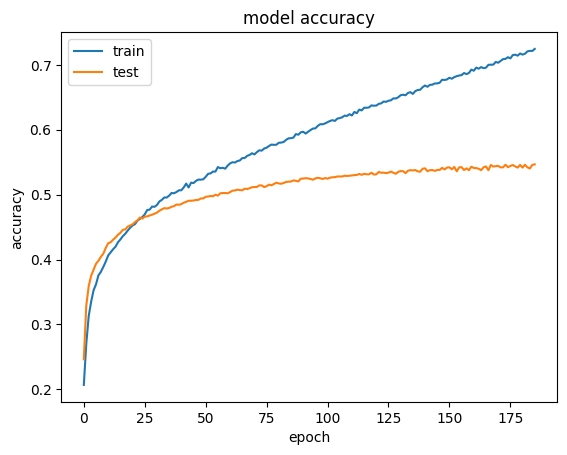

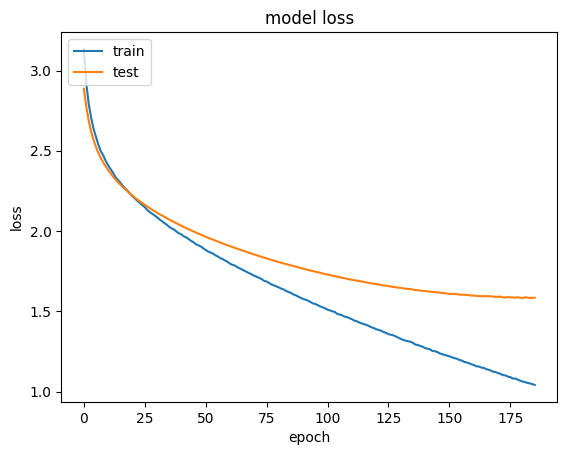

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
#Lets predict on validation data
Y_result= cnn_model.predict(X_val)
print(Y_result)

158/158 [==============================] - 1s 6ms/step
[[0.05258944 0.00506821 0.01853168 ... 0.02665349 0.00159536 0.05459669]
 [0.46373484 0.0273147  0.21577227 ... 0.24572743 0.0188295  0.01773572]
 [0.00666589 0.01921728 0.25806624 ... 0.15985236 0.00658744 0.24434574]
 ...
 [0.13317253 0.00479962 0.03931094 ... 0.03135287 0.00500812 0.01179293]
 [0.10052358 0.05196268 0.09486869 ... 0.18220091 0.02050273 0.19789414]
 [0.03606394 0.0045841  0.00659318 ... 0.0335382  0.00161316 0.00580155]]


In [ ]:
import numpy as np

# Get the predicted class labels based on the highest probability
predicted_labels = np.argmax(Y_result, axis=1)

# You can inverse transform the predicted labels to get the original class names
predicted_emotions = label_encoder.inverse_transform(predicted_labels)

# Create a DataFrame to display the predicted labels
predictions_df = pd.DataFrame({'Predicted_Label': predicted_labels, 'Predicted_Emotion': predicted_emotions})

# Print the DataFrame
print(predictions_df)


      Predicted_Label Predicted_Emotion
0                   3               joy
1                   0             anger
2                   3               joy
3                   7          surprise
4                   0             anger
...               ...               ...
5020                4           neutral
5021                3               joy
5022                4           neutral
5023                7          surprise
5024                4           neutral

[5025 rows x 2 columns]


### LSTM

In [54]:
from keras.layers import LSTM
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen)

lstm_model.add(embedding_layer)
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(128))

lstm_model.add(Dense(8, activation='softmax'))


In [55]:
# Model compiling
opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
lstm_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 100)           2690400   
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 128)           117248    
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 2940264 (11.22 MB)
Trainable params: 2940264 (11.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [56]:
# Model training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1,validation_data=(X_val, y_val),callbacks=[early_stop])

Epoch 1/100
184/184 [==============================] - 101s 513ms/step - loss: 1.6450 - acc: 0.3654 - val_loss: 1.4580 - val_acc: 0.4482
Epoch 2/100
184/184 [==============================] - 96s 522ms/step - loss: 1.4706 - acc: 0.4392 - val_loss: 1.3747 - val_acc: 0.4858
Epoch 3/100
184/184 [==============================] - 88s 480ms/step - loss: 1.3669 - acc: 0.4928 - val_loss: 1.2889 - val_acc: 0.5270
Epoch 4/100
184/184 [==============================] - 97s 526ms/step - loss: 1.2564 - acc: 0.5443 - val_loss: 1.2223 - val_acc: 0.5606
Epoch 5/100
184/184 [==============================] - 93s 505ms/step - loss: 1.1507 - acc: 0.5929 - val_loss: 1.2197 - val_acc: 0.5592
Epoch 6/100
184/184 [==============================] - 90s 491ms/step - loss: 1.0710 - acc: 0.6248 - val_loss: 1.1370 - val_acc: 0.5982
Epoch 7/100
184/184 [==============================] - 93s 505ms/step - loss: 1.0010 - acc: 0.6546 - val_loss: 1.1349 - val_acc: 0.6020
Epoch 8/100
184/184 [==========================

In [57]:
# Predictions on the Test Set

score=lstm_model.evaluate(X_test,y_test)

158/158 [==============================] - 11s 72ms/step - loss: 1.1258 - acc: 0.6173


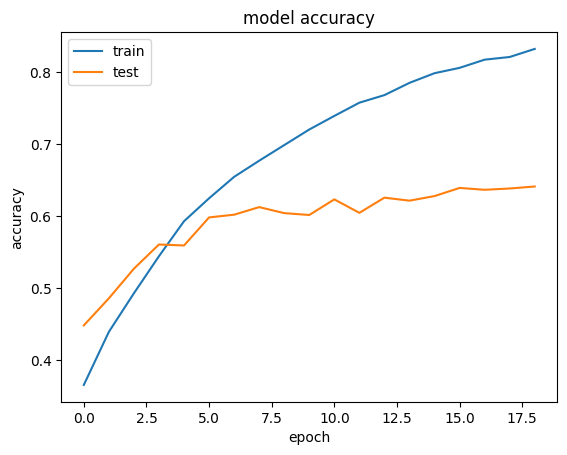

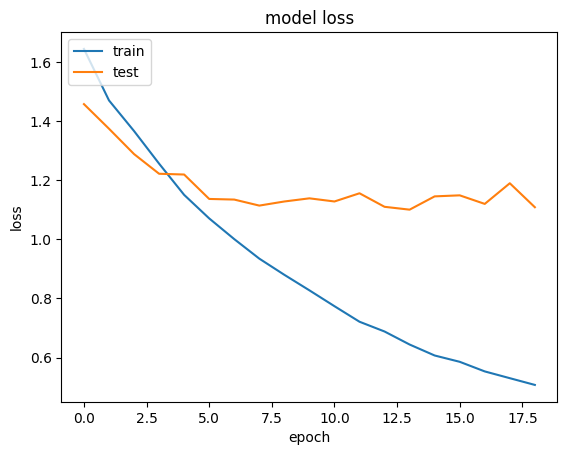

In [58]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()